**Building a Simple Regression Model**

In [1]:
import pandas as pd #data manipulation
from tqdm.auto import tqdm #progress bar
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
import numpy as np #matrix algebra
from lightgbm import LGBMRegressor, plot_importance #LightGBM models
from sklearn.model_selection import train_test_split #ML trainining
from sklearn.metrics import r2_score, mean_squared_error #ML stats
import seaborn as sns #Plotting

Enable Pandas progress_apply

In [2]:
tqdm.pandas()

Read the data

In [3]:
df = pd.read_csv("solubility_data_ok.csv")

Set up property calculations

In [4]:
property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

Define a function to calculate properties from SMILES

In [5]:
def smi2props(smi):
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        props = np.array(property_getter.ComputeProperties(mol))
    return props

Add the properties to the dataframe

In [6]:
df['props'] = df.SMILES.progress_apply(smi2props)

  0%|          | 0/1818 [00:00<?, ?it/s]

RDKit WARNING: [20:31:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:31:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:31:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:31:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:31:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:31:02] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [20:31:02] WARNING: not removing hydrogen atom without neighbors


Put the descriptors into individual columns

In [7]:
df[property_names] = df['props'].to_list()

Split the data into training and test sets

In [8]:
train, test = train_test_split(df)

Define x and y variables for model building

In [9]:
train_X = train[property_names]
train_y = train.Solubility
test_X = test[property_names]
test_y = test.Solubility

Create a LightGBM Regressor

In [10]:
lgbm = LGBMRegressor()

Fit the model

In [11]:
lgbm.fit(train_X, train_y)

LGBMRegressor()

Make the prediction

In [12]:
pred = lgbm.predict(test_X)

Plot predicted vs experimental solubility

<AxesSubplot:xlabel='Solubility'>

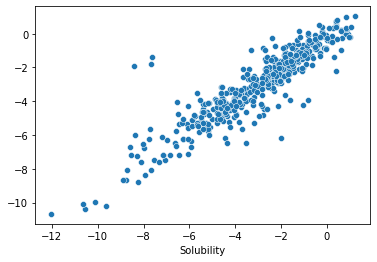

In [13]:
sns.scatterplot(x=test_y,y=pred)

Calculate the coeffcient of determination (R<sup>2</sup>)

In [14]:
r2_score(test_y,pred)

0.826381072929172

Calculate the RMS error

In [15]:
mean_squared_error(test_y,pred,squared=False)

0.9568057104282676

LightGBM provides an easy means of identifying important variables

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

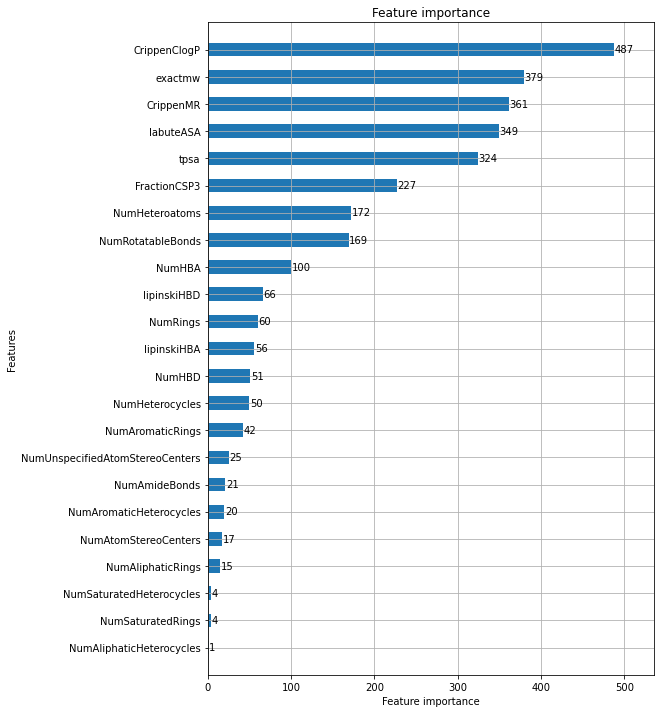

In [16]:
plot_importance(lgbm,figsize=(8,12),height=0.5)

Run 10 cycles of cross validation on a model

0.7859123714241327
0.823644426039584
0.8280174221546074
0.8389333259990526
0.8419156673057648
0.8337707890311226
0.8072056299551243
0.8402531510793378
0.8394442356918463
0.8650173553312475


[Text(0.5, 0, 'R$^2$')]

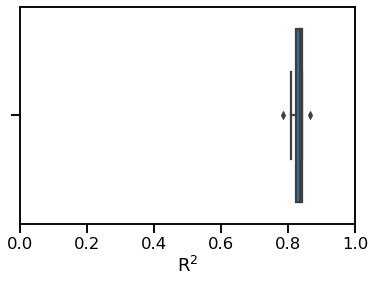

In [25]:
r2_list = []
for i in range(0,10):
    train, test = train_test_split(df)
    train_X = train[property_names]
    train_y = train.Solubility
    test_X = test[property_names]
    test_y = test.Solubility
    lgbm = LGBMRegressor()
    lgbm.fit(train_X,train_y)
    pred = lgbm.predict(test_X)
    r2 = r2_score(test_y,pred)
    print(r2)
    r2_list.append(r2)
sns.set_context('talk')
ax = sns.boxplot(x=r2_list)
ax.set(xlim=(0,1))
ax.set(xlabel="R$^2$")